In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yellowbrick as yb

In [2]:
wines = pd.read_csv('../data/wine.csv')
wines.columns = wines.columns.map(lambda x: x.replace(' ', '_')) # Convert spaces to underscores for easier lookups

In [ ]:
pp.ProfileReport(wines)

# Data Cleaning

Based on the Profile Report above, we have a few things to take care of at the surface level regarding data cleaning:



#### astringency_rating is highly correlated with fixed_acidity (ρ = 0.99262)

Since the correlation is nearly perfect between ```astringency_rating``` and ```fixed_acidity```, we should drop the one with less variance (information), which is ```astringency_rating```.

In [ ]:
wines.drop(['astringency_rating'], axis=1, inplace=True)

#### citric acid has 151 / 2.3% zeros

According to this [link](https://www.livestrong.com/article/189520-what-drinks-do-not-contain-citric-acid/), red wine sometimes doesn't have any citric acid in it, so it makes sense that of all the wines with 0 citric acid, 87% are red.

In [ ]:
wines[wines.citric_acid == 0].groupby('type').citric_acid.count() / 150

#### residual_sugar has 2364 / 36.4% missing values Missing

36.4% missing is cause for concern.

#### vintage has 69 / 1.1% missing values Missing

1.1% missing is pretty small - we can probably drop these observations, or potentially impute them.


#### volatile_acidity has 299 / 4.6% missing values Missing

4.6% missing is also pretty small, so we will probably drop these observations.


#### Dataset has 109 duplicate rows

We need to drop duplicates so that our models don't overfit to a particular observation. To do this, we'll use the ```pandas.DataFrame.drop_duplicates()``` function.

In [3]:
wines.drop_duplicates(inplace=True)

In [ ]:
# wines['red'] = wines.type.map({'red':1, 'white':0})
# wines.drop(columns=['type'], axis=1, inplace=True)

# Visual Exploration

In [ ]:
sns.pairplot(wines.dropna(), hue='type')

Let's get an idea of how qualities are distributed

In [ ]:
sns.countplot(x='quality', hue='type', data=wines)

Most wines are pretty average at around a 6. Very few are 3s or 9s. It looks like white wines tend to do better, though.

In [ ]:
wines.quality.value_counts().sort_index()

In [4]:
wines.dropna(inplace=True)

In [95]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import colorlover as cl

In [6]:
wines['red'] = wines.type.map({'red':1, 'white':0})
wines.drop(columns='type', axis=1, inplace=True)

In [7]:
norm = plt.Normalize()
colors = plt.cm.jet(norm(range(8)))

In [96]:
from sklearn.preprocessing import normalize

explained variance ratio (first two components): [ 0.9532688   0.04031581]


IndexError: index 1 is out of bounds for axis 1 with size 1

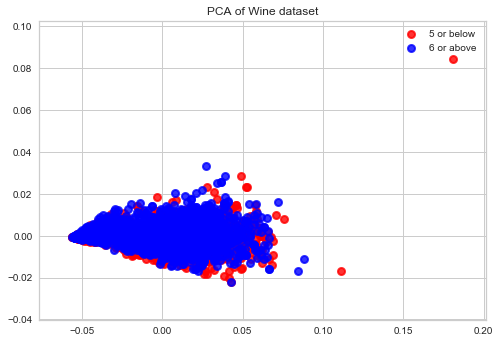

In [100]:
iris = datasets.load_iris()

X = normalize(wines.drop(columns=['quality']))
y = wines.quality.map({3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1})
target_names = ['5 or below', '6 or above']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()

colors = ['red', 'blue']

lw = 2

for color, i, target_name in zip(colors, [0,1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Wine dataset')

plt.figure()
for color, i, target_name in zip(colors, [0,1], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, c=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Wine dataset')

plt.show()

In [ ]:
wines.columns

In [ ]:
wines.quality.value_counts().sort_index()

# Clustering

In [91]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from yellowbrick.classifier import ClassificationReport
from scipy.stats import randint as sp_randint

In [11]:
X = wines.drop(columns=['quality'], axis=1)
y = wines.quality.map({3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1})

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
class DictTransformer(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X.to_dict(orient='records')
    
    def get_params(self, **kwargs):
        return {}

class ArrayTransformer(TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X.toarray()
    
    def get_params(self, **kwargs):
        return {}

In [ ]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
rfc = RandomForestClassifier(n_estimators=50)

rf_model = make_pipeline(dt, dv, at, rfc)

In [19]:
rf_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('dicttransformer', <__main__.DictTransformer object at 0x0000027C1B0393C8>), ('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('arraytransformer', <__main__.ArrayTransformer object at 0x0000027C1B039400>), ('randomforestclassif...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [26]:
def plot_feature_importances(model):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(X.columns, model):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

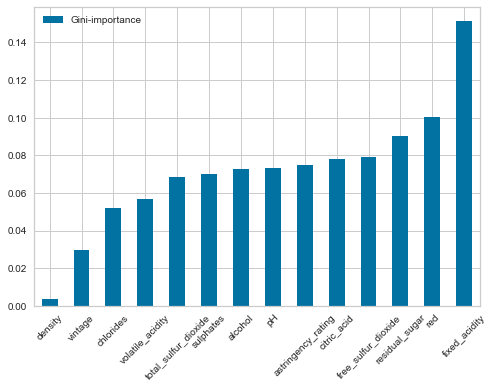

In [27]:
plot_feature_importances(rf_model.steps[3][1].feature_importances_)

In [101]:
param_dist = {"randomforestclassifier__max_depth": [3, None],
              "randomforestclassifier__max_features": sp_randint(1, 14), 
              "randomforestclassifier__min_samples_split": sp_randint(2, 14),
              "randomforestclassifier__min_samples_leaf": sp_randint(1, 14),
              "randomforestclassifier__bootstrap": [True, False],
              "randomforestclassifier__criterion": ["gini", "entropy"]}

n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)

In [102]:
rf_cv_model = random_search.steps[3][1]

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

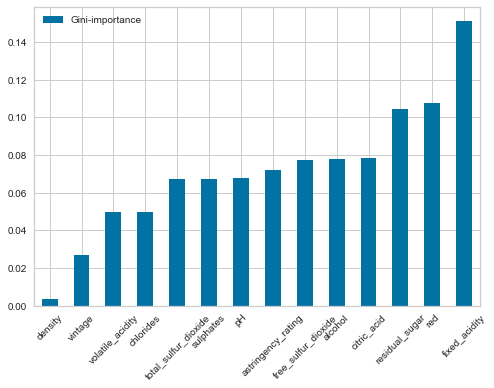

In [44]:
plot_feature_importances(rf_cv_model.feature_importances_)

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(results['mean_test_score'][candidate], results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
                  

In [51]:
dt = DictTransformer()
dv = DictVectorizer()
at = ArrayTransformer()
en = ElasticNetCV()

en_cv_model = make_pipeline(dt, dv, at, en)

In [52]:
en_cv_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('dicttransformer', <__main__.DictTransformer object at 0x0000027C1B08AF98>), ('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('arraytransformer', <__main__.ArrayTransformer object at 0x0000027C1B08A320>), ('elasticnetcv', Elas...ive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0))])

In [80]:
en_drop_cols = []
for feature, coef in zip(X.columns, en_cv_model.steps[3][1].coef_):
    if coef == 0:
        en_drop_cols.append(feature)

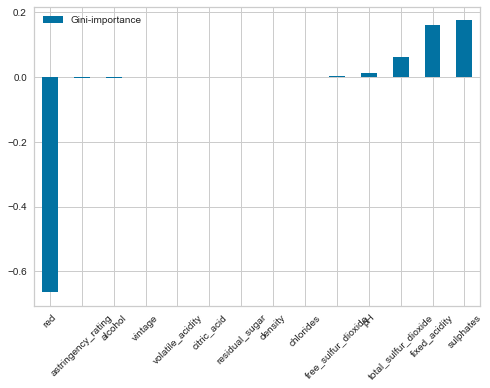

In [53]:
plot_feature_importances(en_cv_model.steps[3][1].coef_)

## Ordinal Logistic Regression

In [ ]:
import mord
from sklearn import linear_model, metrics, preprocessing

In [81]:
en_drop_cols.append('quality')

In [87]:
X = wines.drop(columns=['quality'], axis=1)
y = wines.quality.map({3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1})

In [88]:
y.value_counts()

1    2273
0    1303
Name: quality, dtype: int64

In [92]:
lr1 = LogisticRegressionCV(
    solver='lbfgs')
lr1.fit(X, y)
print('Mean Absolute Error of LogisticRegression: %s' %
      mean_absolute_error(lr1.predict(X), y))

Mean Absolute Error of LogisticRegression: 0.267058165548


In [93]:
lr1.coef_

array([[-0.0078225 , -1.86271817,  0.13417779, -0.18847184,  0.05816355,
        -0.134092  ,  0.02233237, -0.0074891 , -0.00467038,  0.20338035,
         1.03992636,  0.93711302, -0.00477626, -0.22280938]])

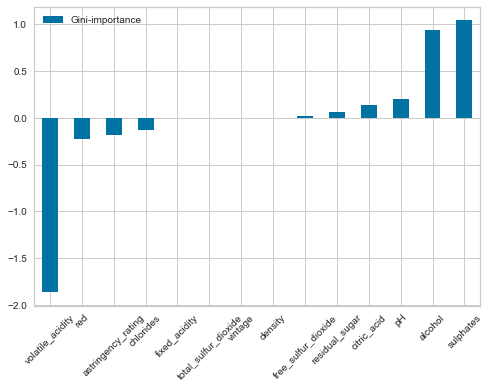

In [94]:
plot_feature_importances(lr1.coef_[0])

Mean Absolute Error of LogisticAT 0.25755033557


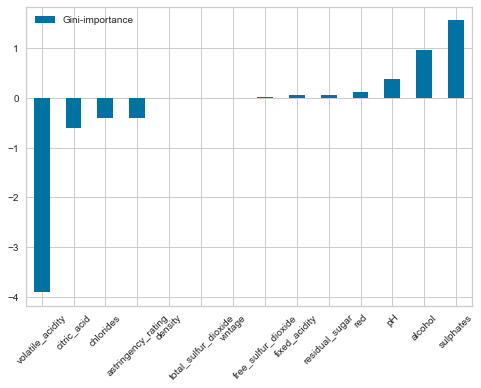

In [77]:
clf2 = mord.LogisticAT(alpha=1.)
clf2.fit(X, y)
print('Mean Absolute Error of LogisticAT %s' %
      mean_absolute_error(clf2.predict(X), y))
plot_feature_importances(clf2.coef_)

Mean Absolute Error of LogisticIT 0.25755033557


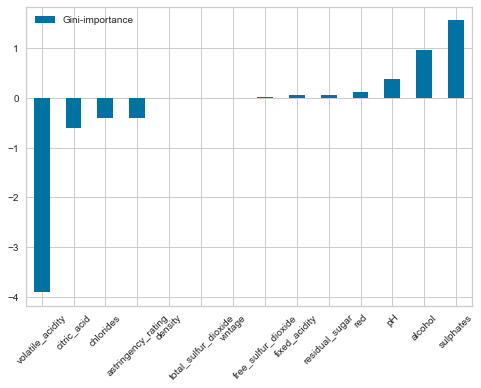

In [78]:
clf3 = mord.LogisticIT(alpha=1.)
clf3.fit(X, y)
print('Mean Absolute Error of LogisticIT %s' %
      metrics.mean_absolute_error(clf3.predict(X), y))
plot_feature_importances(clf3.coef_)

Mean Absolute Error of LogisticSE 0.25615212528


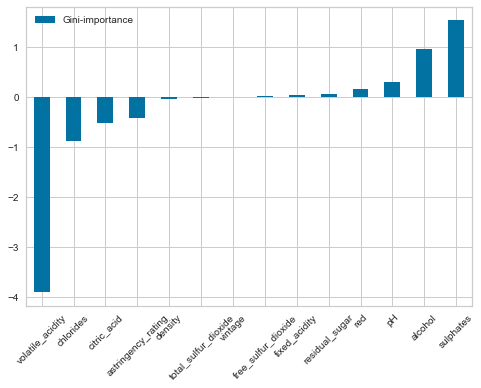

In [79]:
clf4 = mord.LogisticSE(alpha=1.)
clf4.fit(X, y)
print('Mean Absolute Error of LogisticSE %s' %
      metrics.mean_absolute_error(clf4.predict(X), y))
plot_feature_importances(clf4.coef_)

In [ ]:
X_subset = wines[wines.quality.isin([5, 6])].drop(['quality'], axis=1)
y_subset = wines[wines.quality.isin([5, 6])].quality.map({5:0, 6:1})

In [ ]:
clf1 = linear_model.LogisticRegressionCV()
clf1.fit(X_subset, y_subset)
print('Mean Absolute Error of LogisticRegression: %s' %
      metrics.mean_absolute_error(clf1.predict(X_subset), y_subset))

In [ ]:
print(metrics.classification_report(clf1.predict(X_subset), y_subset))

In [ ]:
print(metrics.accuracy_score(clf1.predict(X_subset), y_subset))

In [ ]:
X_subset = wines.drop(['quality'], axis=1)
y_subset = wines.quality.map({3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1})

In [ ]:
clf1 = linear_model.LogisticRegressionCV()
clf1.fit(X_subset, y_subset)
print('Mean Absolute Error of LogisticRegression: %s' %
      metrics.mean_absolute_error(clf1.predict(X_subset), y_subset))

In [ ]:
print(metrics.classification_report(clf1.predict(X_subset), y_subset))

In [ ]:
print(metrics.accuracy_score(clf1.predict(X_subset), y_subset))

In [ ]:
y_subset.value_counts() / y_subset.size